### Project Setup

In [2136]:
!pip install seaborn
!pip install scipy
!pip install scikit-learn

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import pointbiserialr
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python3 -m pip install --upgrade pip


### Citirea setului de date

In [2137]:
# Citirea setului de date
df = pd.read_csv('dataset.csv')

### Filtrarea datelor

In [2138]:
# Eliminam din dataset NaN si +- Inifity
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

In [2139]:
# Inlocuiesc NaN si +- Infinity cu mediana pe coloane pentru
#df = df.replace([np.inf, -np.inf], np.nan)
#df = df.apply(lambda x: x.fillna(x.median()), axis=0)

# 3.1. Explorarea Datelor (Exploratory Data Analysis)

## 1. Analiza Echilibrului de Clase

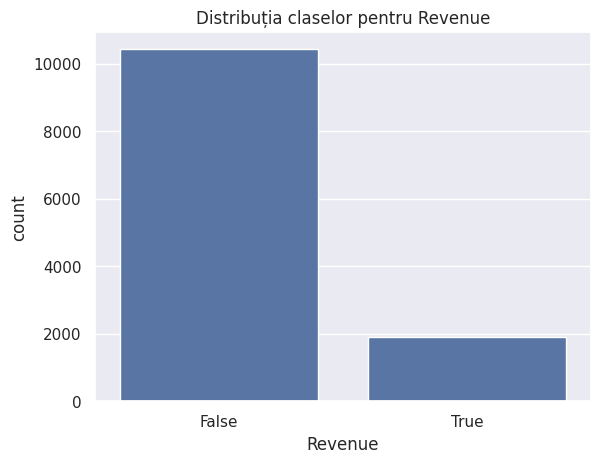

In [2140]:
# Verificarea echilibrului claselor
sns.countplot(x='Revenue', data=df)
plt.title('Distribuția claselor pentru Revenue')
plt.show()

## 2. Vizualizarea Atributelor

### 2.A Atribute Numerice

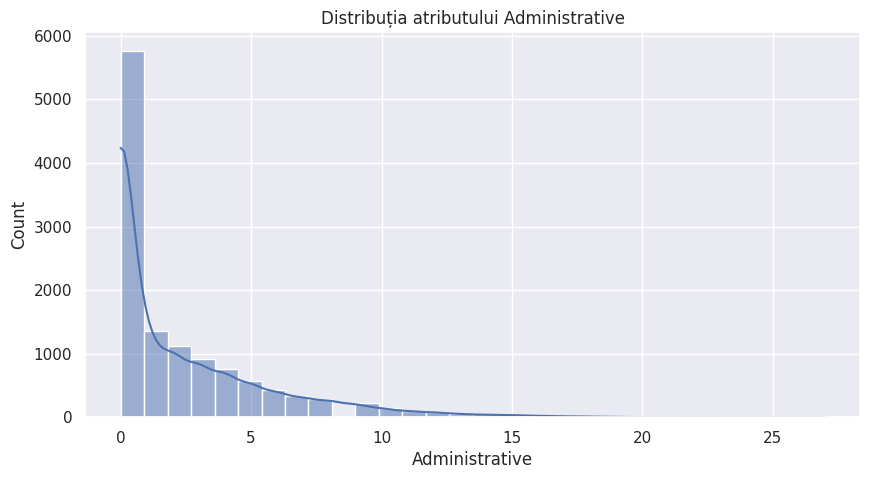

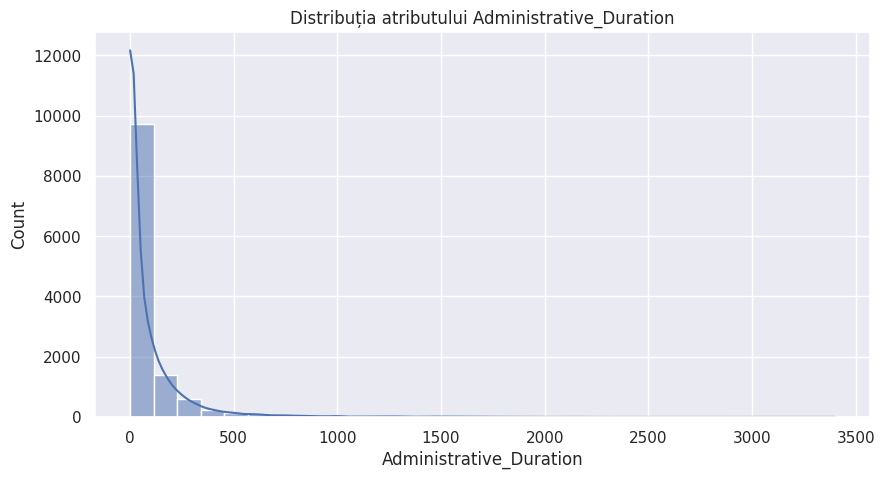

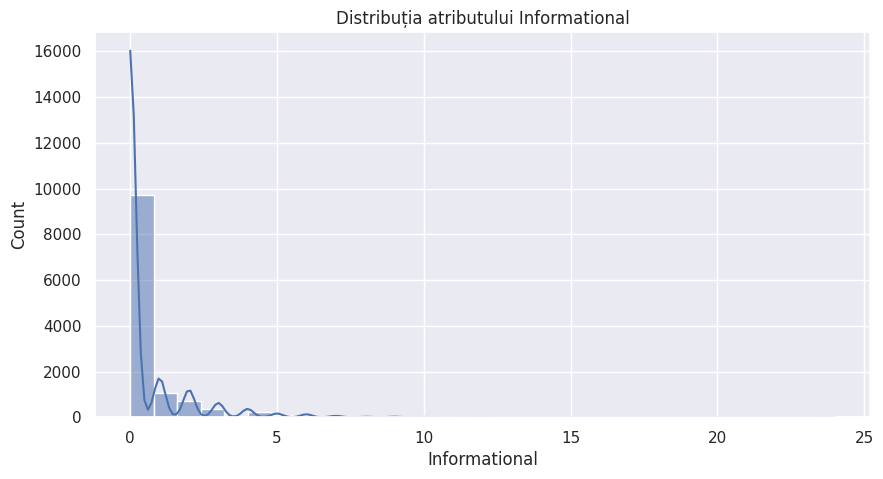

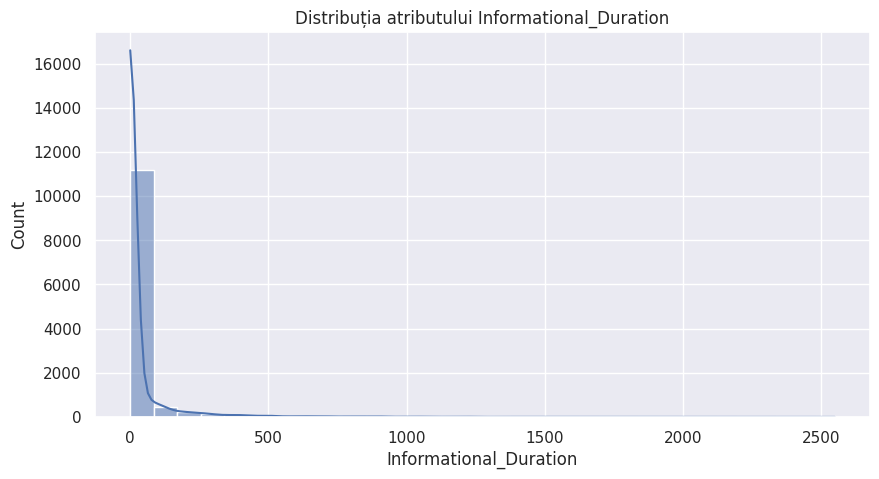

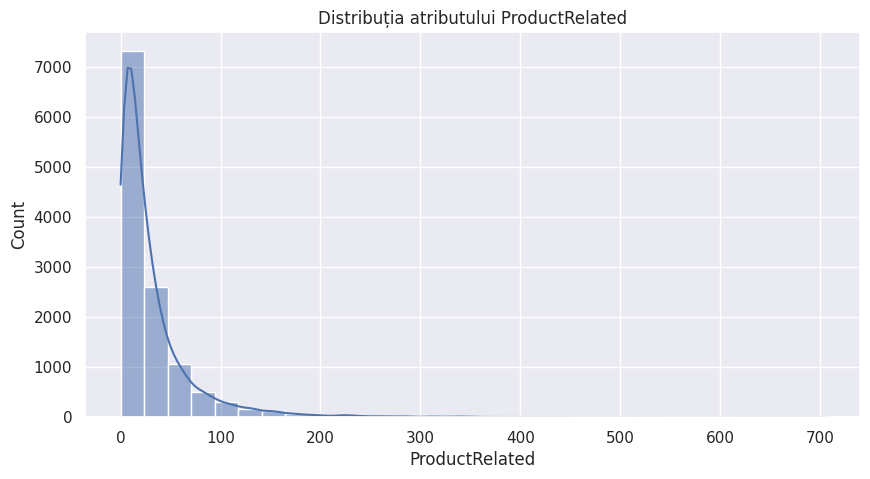

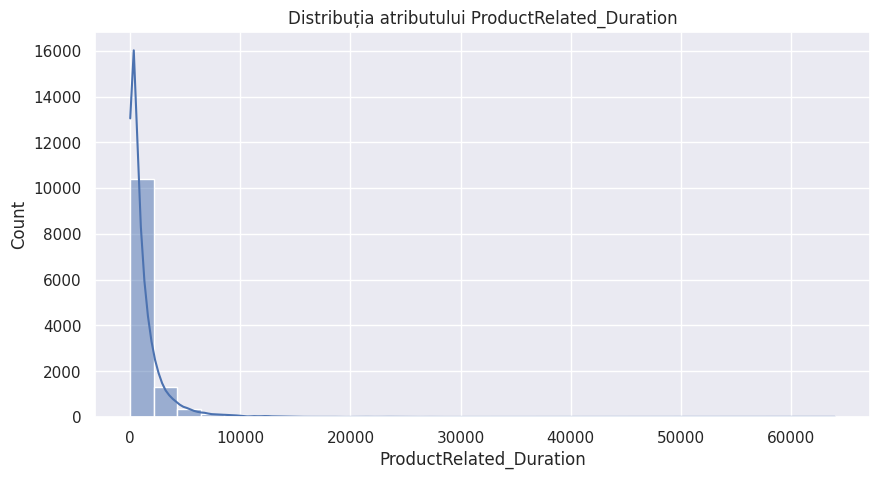

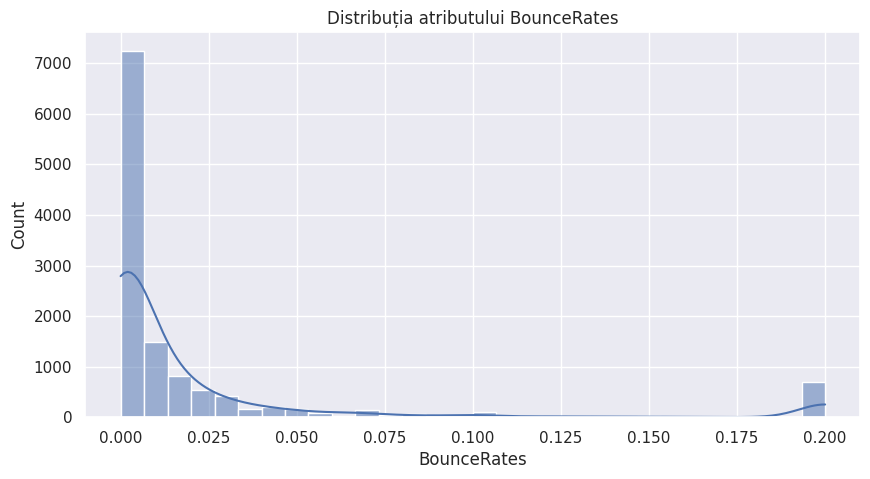

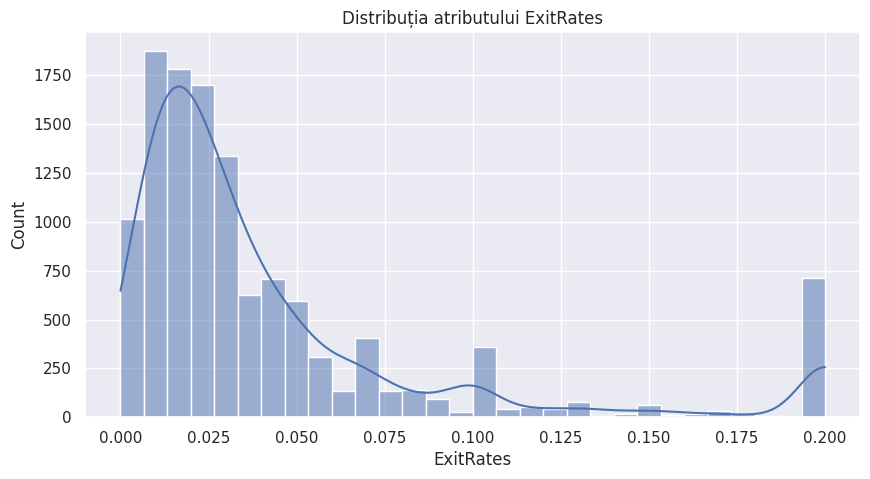

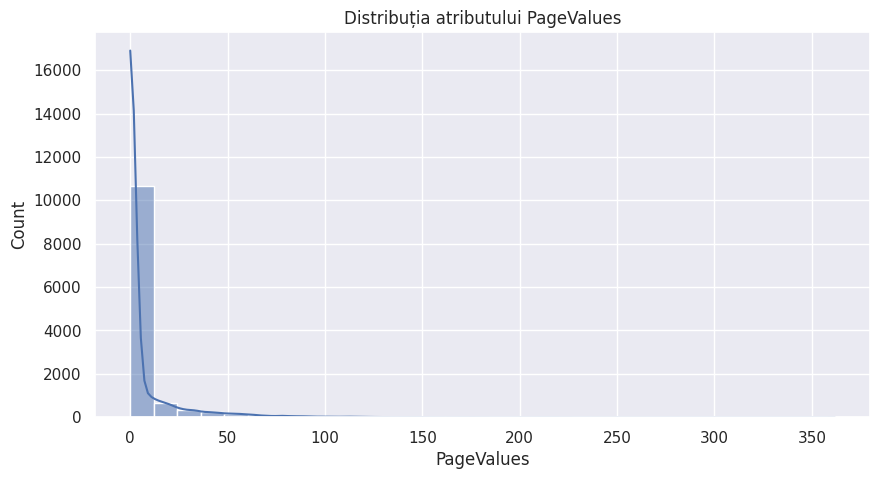

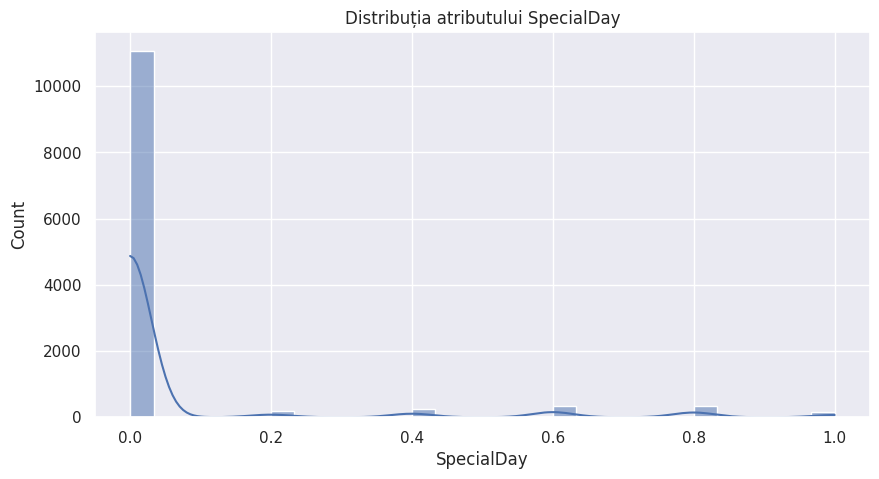

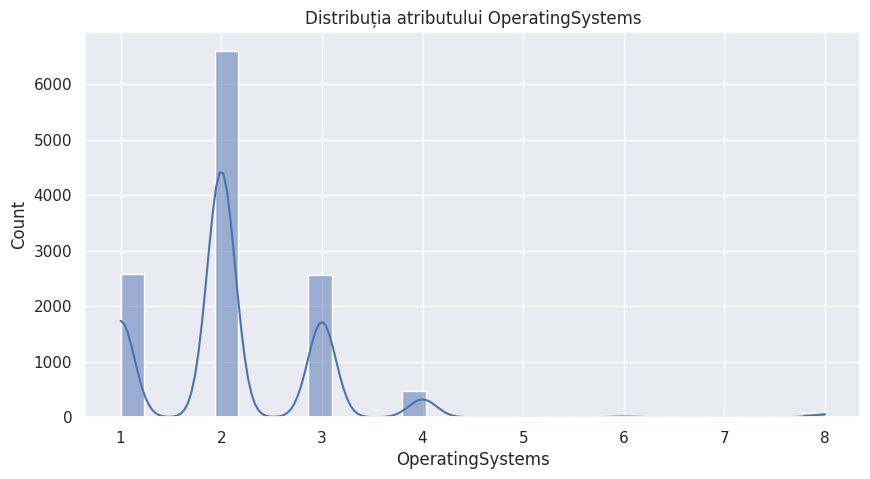

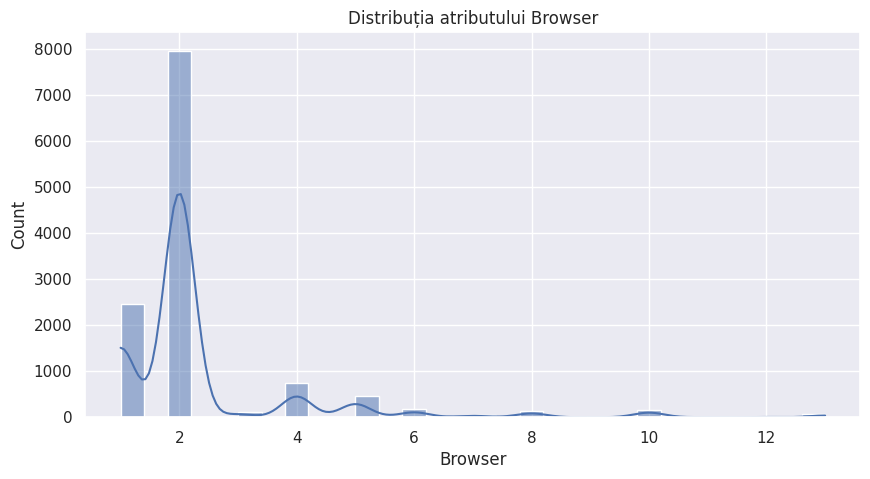

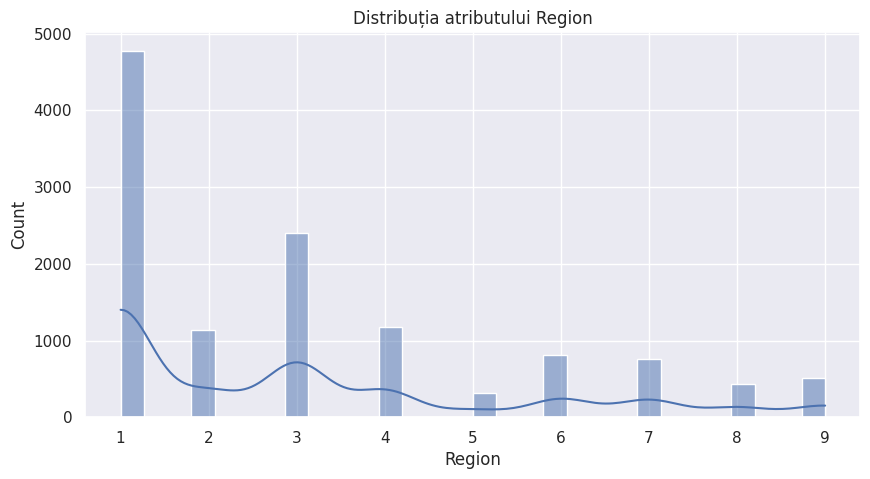

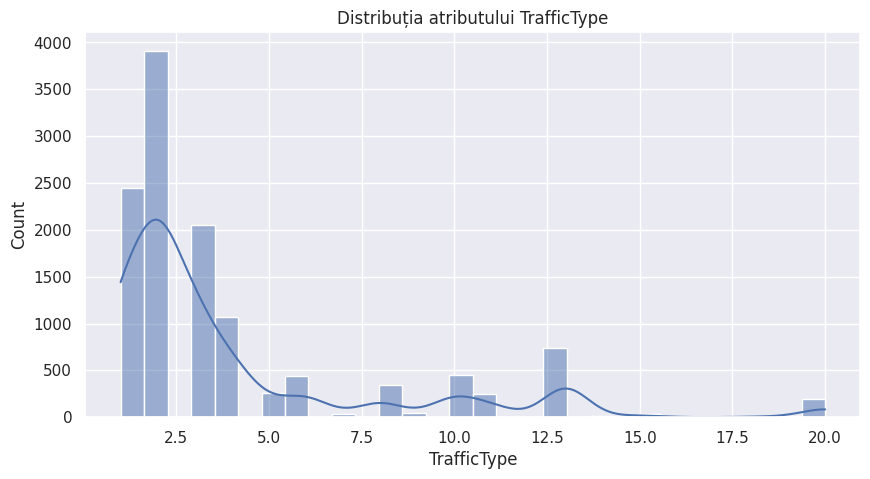

In [2141]:
# Identificarea atributelor numerice
numeric_attributes = df.select_dtypes(include=np.number).columns.tolist()

# Vizualizare distribuție pentru atribute numerice
for attribute in numeric_attributes:
    plt.figure(figsize=(10, 5))
    sns.histplot(df[attribute], bins=30, kde=True)
    plt.title(f'Distribuția atributului {attribute}')
    plt.show()

### 2.A Atribute Categorice

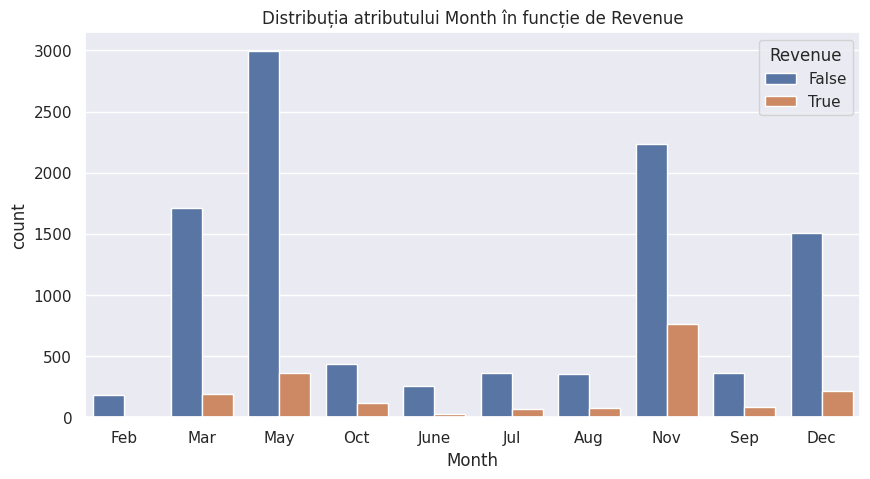

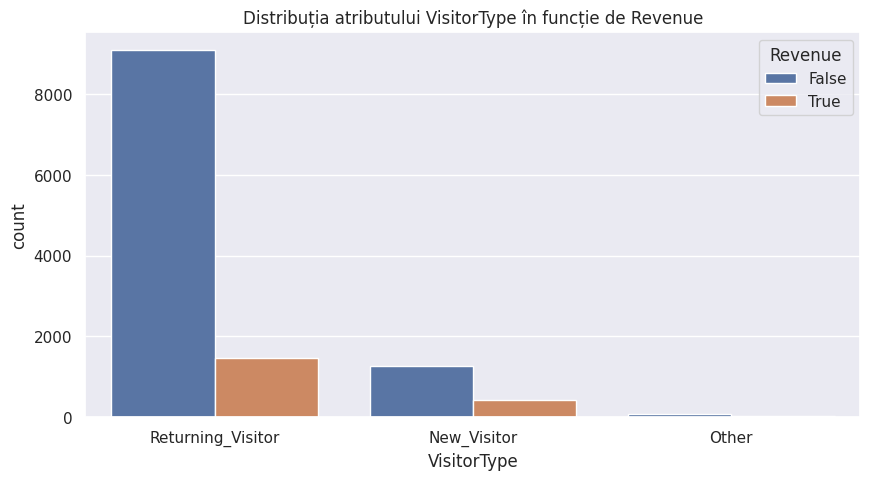

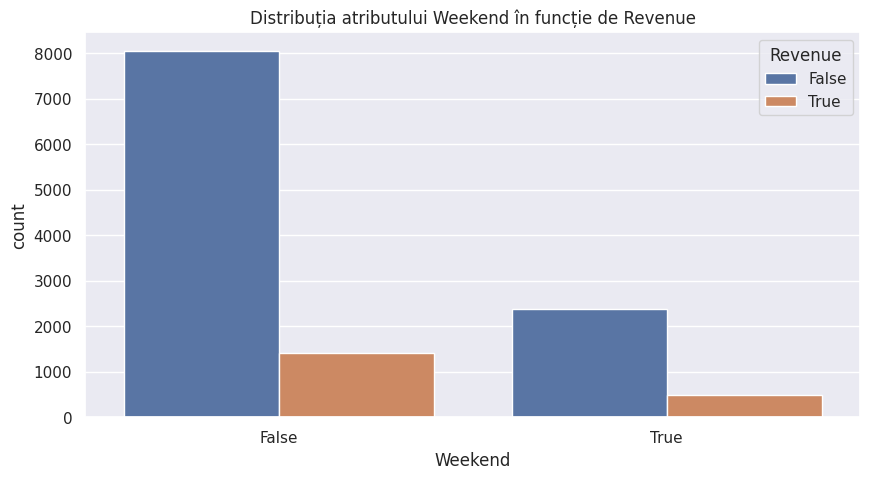

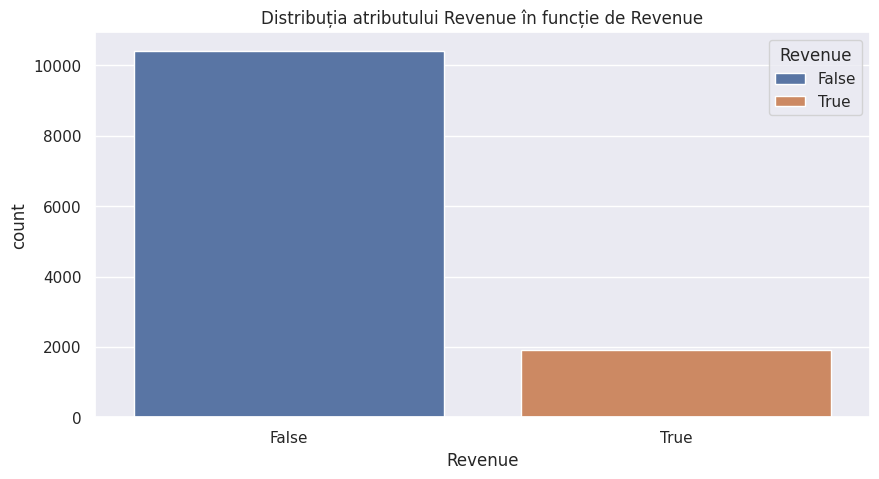

In [2142]:
# Identificarea atributelor categorice
categorical_attributes = df.select_dtypes(exclude=np.number).columns.tolist()

# Vizualizare distribuție pentru atribute categorice
for attribute in categorical_attributes:
    plt.figure(figsize=(10, 5))
    sns.countplot(x=attribute, data=df, hue='Revenue')
    plt.title(f'Distribuția atributului {attribute} în funcție de Revenue')
    plt.show()


## 3. Analiza Gradului de Corelare

### 3.A Atribute Numerice cu Coeficientul de Point-Biserial

                  Attribute  Correlation        P-Value
0            Administrative     0.138917   3.519760e-54
1   Administrative_Duration     0.093587   2.146514e-25
2             Informational     0.095200   3.174034e-26
3    Informational_Duration     0.070345   5.282871e-15
4            ProductRelated     0.158538   3.241187e-70
5   ProductRelated_Duration     0.152373   6.115338e-65
6               BounceRates    -0.150673   1.594198e-63
7                 ExitRates    -0.207071  1.662654e-119
8                PageValues     0.492569   0.000000e+00
9                SpecialDay    -0.082305   5.498934e-20
10         OperatingSystems    -0.014668   1.033943e-01
11                  Browser     0.023984   7.736888e-03
12                   Region    -0.011595   1.979426e-01
13              TrafficType    -0.005113   5.702434e-01




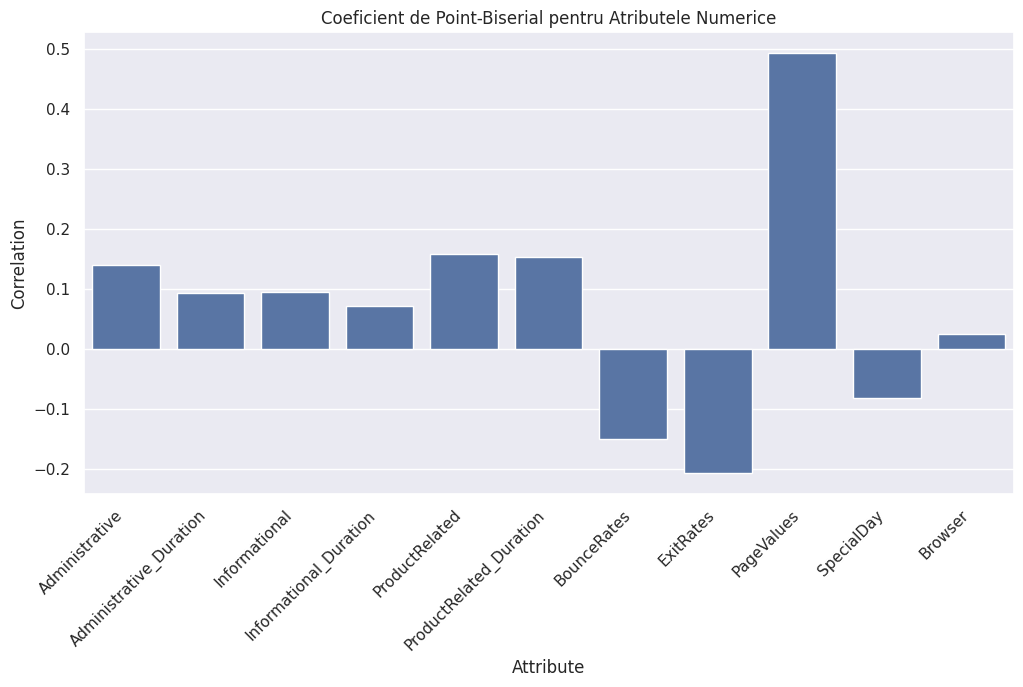

In [2143]:
correlation_results_numeric = []

for attribute in numeric_attributes:
    if attribute != 'Revenue':
        correlation, p_value = pointbiserialr(df[attribute], df['Revenue'])
        correlation_results_numeric.append({'Attribute': attribute, 'Correlation': correlation, 'P-Value': p_value})

# Tabelul cu rezultate
correlation_df_numeric = pd.DataFrame(correlation_results_numeric)
print(correlation_df_numeric)
print('\n')

# Vizualizare pentru atributele cu p-value <= 0.05
significant_numeric_attributes = correlation_df_numeric[correlation_df_numeric['P-Value'] <= 0.05]
plt.figure(figsize=(12, 6))
barplot = sns.barplot(x='Attribute', y='Correlation', data=significant_numeric_attributes)
plt.title('Coeficient de Point-Biserial pentru Atributele Numerice')

# Rotirea etichetelor pe axa X pentru a face vizualizarea mai lizibilă
X_fields = significant_numeric_attributes['Attribute'].tolist()
barplot.set_xticks(range(len(X_fields)))
barplot.set_xticklabels(X_fields, rotation=45, horizontalalignment='right')

plt.show()

### 3.B Atribute Categorice cu Testul Chi-squared

     Attribute   Chi-squared       P-Value
0        Month    384.934762  2.238786e-77
1  VisitorType    135.251923  4.269904e-30
2      Weekend     10.390978  1.266325e-03
3      Revenue  12322.355847  0.000000e+00




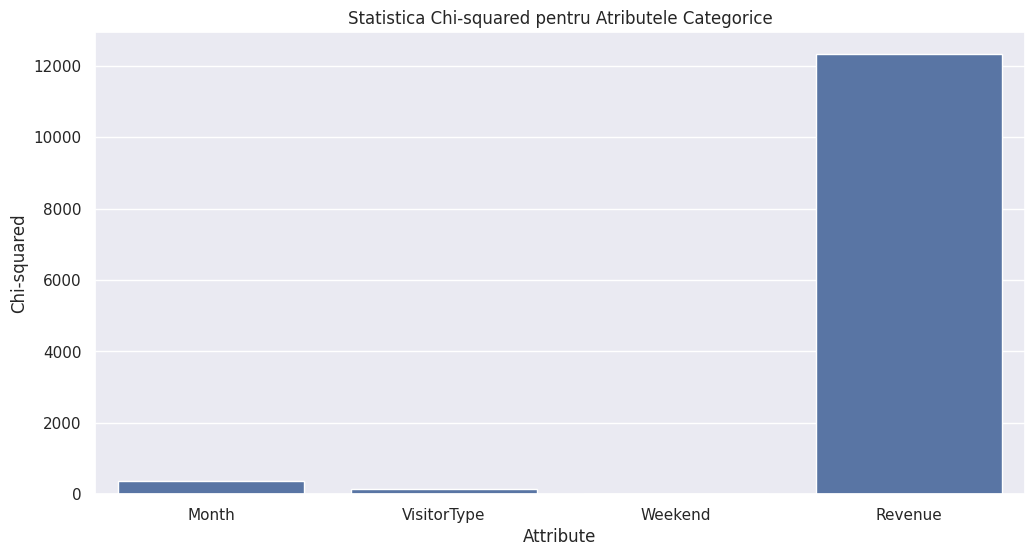

In [2144]:
correlation_results_categorical = []

for attribute in categorical_attributes:
    contingency_table = pd.crosstab(df[attribute], df['Revenue'])
    chi2, p_value, _, _ = chi2_contingency(contingency_table)
    correlation_results_categorical.append({'Attribute': attribute, 'Chi-squared': chi2, 'P-Value': p_value})

# Tabelul cu rezultate
correlation_df_categorical = pd.DataFrame(correlation_results_categorical)
print(correlation_df_categorical)
print('\n')

# Vizualizare pentru atributele cu p-value <= 0.05
significant_categorical_attributes = correlation_df_categorical[correlation_df_categorical['P-Value'] <= 0.05]
plt.figure(figsize=(12, 6))
sns.barplot(x='Attribute', y='Chi-squared', data=significant_categorical_attributes)
plt.title('Statistica Chi-squared pentru Atributele Categorice')
plt.show()


# 3.2. Antrenarea și Evaluarea Algoritmilor de Predicție

#### Setting some variables needed for the comparison

In [2145]:
# Plot X axis step
STEP_PERCENT=1.25
# Number of times to run the function
num_iterations = 10

## 3.2.1. Regresie Logistică

### 1. Implementare manuală

#### Regresia Logistica

In [2146]:
clipped_value = 500

def split_dataset(X, T, train=.8):
    N = X.shape[0]
    N_train = int(round(N * train))
    N_test = N - N_train

    X_train, X_test = X[:N_train, :], X[N_train:, :]
    T_train, T_test = T[:N_train], T[N_train:]
    return X_train, T_train, X_test, T_test

def logistic(x):
    # Clip the input values to prevent overflow
    clipped_x = np.clip(x, -clipped_value, clipped_value)
    
    # Calculate the logistic function on the clipped values
    return 1 / (1 + np.exp(-clipped_x))

# Negative Log Likelihood - functia J(w)
def nll(Y, T):
    epsilon = 1e-15
    Y = np.clip(Y, epsilon, 1 - epsilon)
    return -np.mean(T * np.log(Y) + (1 - T) * np.log(1 - Y))

def accuracy(Y, T):
    predicted_labels = np.round(Y)
    correct_predictions = np.sum(predicted_labels == T)
    total_samples = len(T)
    return correct_predictions / total_samples

# Antrenati modelul logistic (ponderile W), executand epochs_no pasi din algoritmul de gradient descent
def train_logistic(X, T, lr=0.01, epochs_no=100):
    (N, D) = X.shape
    X_hat = np.concatenate([X, np.ones((N, 1))], axis=1)
    W = np.random.randn(D + 1)

    for epoch in range(epochs_no):
        Y = logistic(np.dot(X_hat, W))
        gradient = np.dot(X_hat.T, (Y - T))
        W -= lr * gradient

    return W

# Calculati predictia Y a modelului logistic antrenat (ponderile W invatate)
def predict_logistic(X, W):
    X_hat = np.concatenate([X, np.ones((X.shape[0], 1))], axis=1)
    Y = logistic(np.dot(X_hat, W))
    return Y

def train_logistic_full(X, T, lr=0.01, learning_increase_percent=2.5, epochs_no=1000):
    (N, D) = X.shape
    X1 = np.concatenate([np.ones((N, 1)), X], axis=1)
    W = np.random.randn(D + 1)

    X_train, T_train, X_test, T_test = split_dataset(X1, T)
    
    train_acc, test_acc = [], []
    train_nll, test_nll = [], []
    W_trace = [W.copy()]

    for epoch in range(epochs_no):
        # Maresc learning rate-ul pt fiecare epoch
        lr = lr * (1 + learning_increase_percent / 100) 
        
        Y_train = logistic(X_train @ W)
        
        gradient = np.transpose(X_train) @ (Y_train-T_train)/N
        W -= lr * gradient

        logits = np.dot(X_test, W)
        Y_test = 1. / (1. + np.exp(-np.clip(logits, -clipped_value, clipped_value)))

        train_acc.append(accuracy(Y_train, T_train))
        test_acc.append(accuracy(Y_test, T_test))
        train_nll.append(nll(Y_train, T_train))
        test_nll.append(nll(Y_test, T_test))
        W_trace.append(W.copy())

    return W, train_acc, test_acc, train_nll, test_nll, W_trace

#### Preprocesarea datelor

In [2147]:
def preprocess_data(df):
    # Split set de date în caracteristici (X) și variabilă țintă (y)
    X = df.drop('Revenue', axis=1)
    y = df['Revenue'] # Revenue este boolean ( 0 / 1)
    
    # Conversia variabilelor categorice în formă numerică
    label_encoder = LabelEncoder()
    categorical_columns = ['Month', 'VisitorType', 'Weekend']
    for column in categorical_columns:
        X[column] = label_encoder.fit_transform(X[column])

    return X, y

#### Functie pentru plotting

In [2148]:
# Definim o functie ajutatoare pentru plotting
def plot_evolution(train_acc, test_acc, train_nll, test_nll, scaler, step_percent=2.5):
    # Step_percent = 5 <==> 100 / 5 == 20 X points on the plot
    epochs_no = len(train_acc)
    step = round(epochs_no * step_percent / 100)
    # If step is 0, we will set minimum default step for the plotting
    if step == 0:
        step = 1
    fig, (ax1, ax2) = plt.subplots(2, 1)

    # Plotting accuracy evolution
    ax1.plot(range(0, epochs_no, step), train_acc[::step], sns.xkcd_rgb["green"], label="Train Accuracy")
    ax1.plot(range(0, epochs_no, step), test_acc[::step], sns.xkcd_rgb["red"], label="Test Accuracy")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc='lower right', ncol=1)

    # Plotting negative log likelihood evolution
    ax2.plot(range(0, epochs_no, step), train_nll[::step], sns.xkcd_rgb["green"], label="Train NLL")
    ax2.plot(range(0, epochs_no, step), test_nll[::step], sns.xkcd_rgb["red"], label="Test NLL")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("NLL")
    ax2.legend(loc='upper right', ncol=1)

    # Adding title with scaler information
    plt.suptitle(f'Evolution with Scaler: {scaler}')
    plt.show()
    
    return (ax1, ax2)

In [2149]:
# Function to print metrics for a specific measure (e.g., accuracy, precision, recall, f1_score)
def print_metrics(metric_name, results_dict, num_iterations):
    for scaler_name, metric_list in results_dict.items():
        mean_metric = np.mean(metric_list)
        median_metric = np.median(metric_list)
        variance_metric = np.var(metric_list)
        min_metric = np.min(metric_list)
        max_metric = np.max(metric_list)

        print(f"\nMetrics for {metric_name} with {scaler_name} after {num_iterations} runs:")
        print(f"Mean {metric_name}: {mean_metric}")
        print(f"Median {metric_name}: {median_metric}")
        print(f"Variance {metric_name}: {variance_metric}")
        print(f"Min {metric_name}: {min_metric}")
        print(f"Max {metric_name}: {max_metric}")

#### Datele de fitting ale modelului

In [2150]:
EPOCHS_NO = 200
LR = 0.035
LEARNING_INCREASE_PERCENT = 1

### Scalers

In [2151]:
# Normalizarea datelor (Scalare)
scalers = {
        'MinMaxScaler': MinMaxScaler(),
        'StandardScaler': StandardScaler(),
        'RobustScaler': RobustScaler()
}

In [2152]:
def logistic_regression_manual(X, y, lr=0.01, learning_increase_percent=2.5, epochs_no=100, step_percent=100):
    for scaler_name, scaler in scalers.items():
        # Split the dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
        
        # Scalarea datelor de antrenare
        X_train_scaled = scaler.fit_transform(X_train)

        # Antrenarea modelului logistic
        W, train_acc, test_acc, train_nll, test_nll, W_trace = train_logistic_full(X_train_scaled, y_train, lr=lr, epochs_no=epochs_no)

        # Evaluarea modelului pe setul de testare
        X_test_scaled = scaler.transform(X_test)
        Y_test = predict_logistic(X_test_scaled, W)

        # Evaluare metrici pe setul de testare
        precision = precision_score(y_test, np.round(Y_test))
        recall = recall_score(y_test, np.round(Y_test))
        f1 = f1_score(y_test, np.round(Y_test))
        test_accuracy = accuracy(Y_test, y_test)

        # Afișare și salvare metrici
        print(f"Acuratete folosind {scaler_name}: {test_accuracy}")
        print(f"Precision folosind {scaler_name}: {precision}")
        print(f"Recall folosind {scaler_name}: {recall}")
        print(f"F1 Score folosind {scaler_name}: {f1}")
        
        # Save metric values in dictionaries
        if scaler_name not in precision_results:
            precision_results[scaler_name] = []
        precision_results[scaler_name].append(precision)
        if scaler_name not in recall_results:
            recall_results[scaler_name] = []
        recall_results[scaler_name].append(recall)
        if scaler_name not in f1_score_results:
            f1_score_results[scaler_name] = []
        f1_score_results[scaler_name].append(f1)
        if scaler_name not in accuracy_results:
            accuracy_results[scaler_name] = []
        accuracy_results[scaler_name].append(test_accuracy)

        # Vizualizare evolutie
        plot_evolution(train_acc, test_acc, train_nll, test_nll, scaler, step_percent)
        
        # Eliberare memorie
        del X_train, X_train_scaled, X_test_scaled, Y_test, W, train_acc, test_acc, train_nll, test_nll, W_trace

### Rulam de 10 ori algoritmul pe sample-uri random ale datasetului initial

Training dataset size: 12330
Number of features: 17

RULAREA NUMARUL 1
Acuratete folosind MinMaxScaler: 0.8491484184914841
Precision folosind MinMaxScaler: 0.0
Recall folosind MinMaxScaler: 0.0
F1 Score folosind MinMaxScaler: 0.0


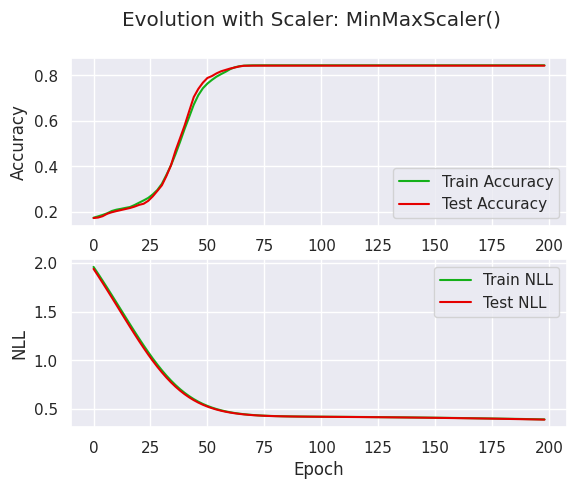

Acuratete folosind StandardScaler: 0.43795620437956206
Precision folosind StandardScaler: 0.13539367181751288
Recall folosind StandardScaler: 0.46582278481012657
F1 Score folosind StandardScaler: 0.209806157354618


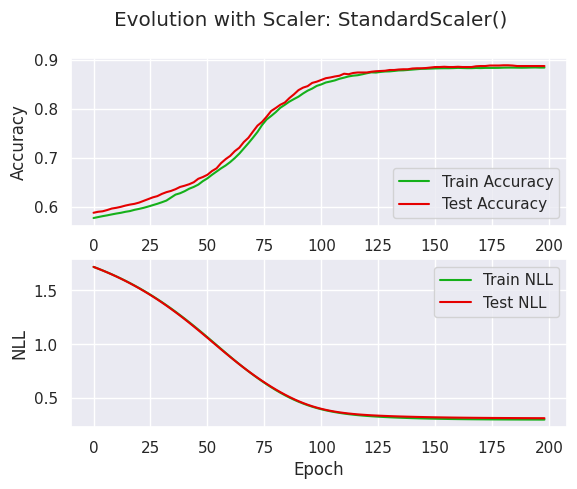

Acuratete folosind RobustScaler: 0.605433901054339
Precision folosind RobustScaler: 0.044977511244377814
Recall folosind RobustScaler: 0.08196721311475409
F1 Score folosind RobustScaler: 0.05808325266214908


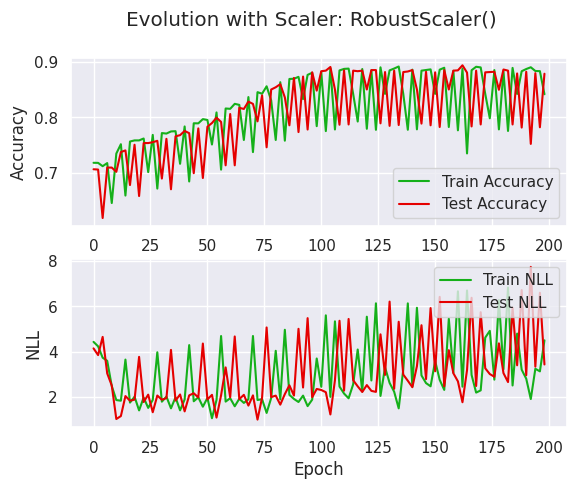


RULAREA NUMARUL 2
Acuratete folosind MinMaxScaler: 0.7806163828061639
Precision folosind MinMaxScaler: 0.09944751381215469
Recall folosind MinMaxScaler: 0.045454545454545456
F1 Score folosind MinMaxScaler: 0.06239168110918545


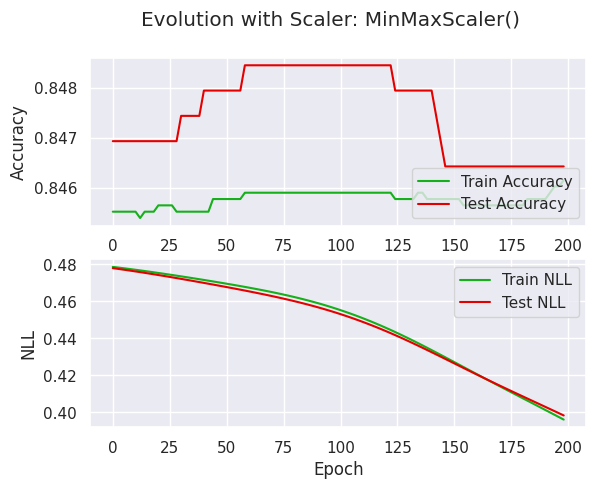

Acuratete folosind StandardScaler: 0.32116788321167883
Precision folosind StandardScaler: 0.06340819022457067
Recall folosind StandardScaler: 0.2727272727272727
F1 Score folosind StandardScaler: 0.10289389067524114


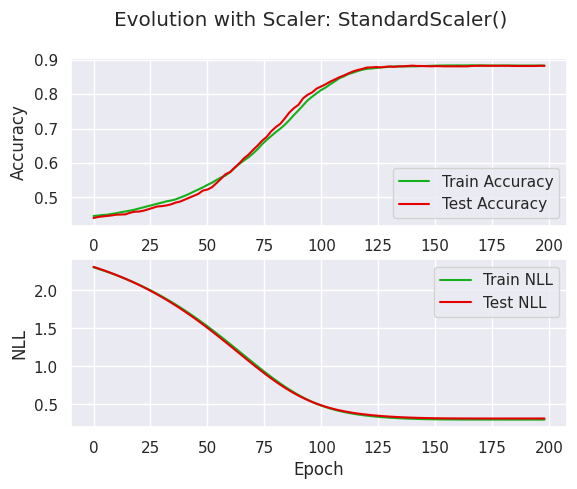

Acuratete folosind RobustScaler: 0.46958637469586373
Precision folosind RobustScaler: 0.030864197530864196
Recall folosind RobustScaler: 0.07575757575757576
F1 Score folosind RobustScaler: 0.043859649122807015


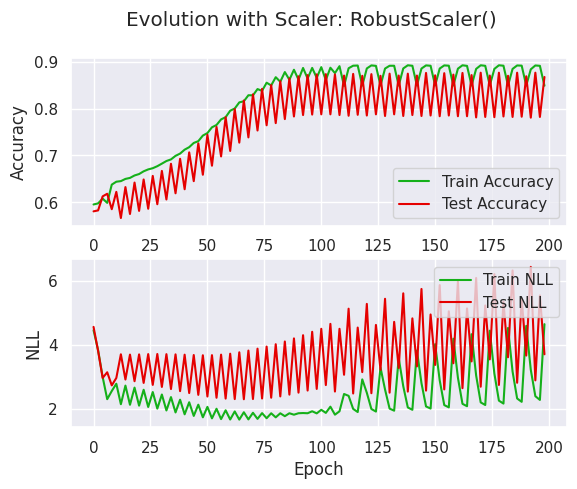


RULAREA NUMARUL 3
Acuratete folosind MinMaxScaler: 0.5758313057583131
Precision folosind MinMaxScaler: 0.15040650406504066
Recall folosind MinMaxScaler: 0.4134078212290503
F1 Score folosind MinMaxScaler: 0.22056631892697467


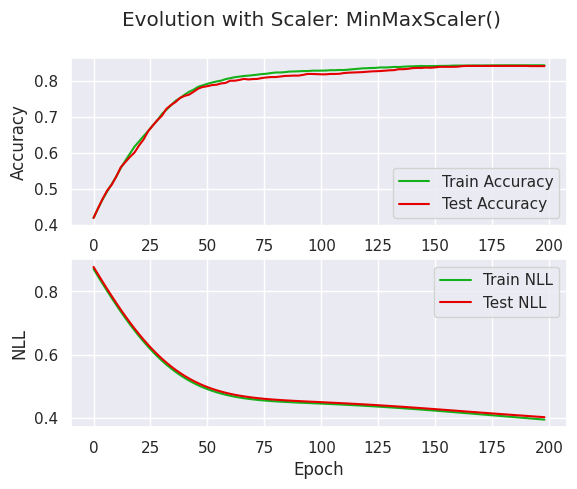

Acuratete folosind StandardScaler: 0.32927818329278186
Precision folosind StandardScaler: 0.05146036161335188
Recall folosind StandardScaler: 0.2032967032967033
F1 Score folosind StandardScaler: 0.08213096559378469


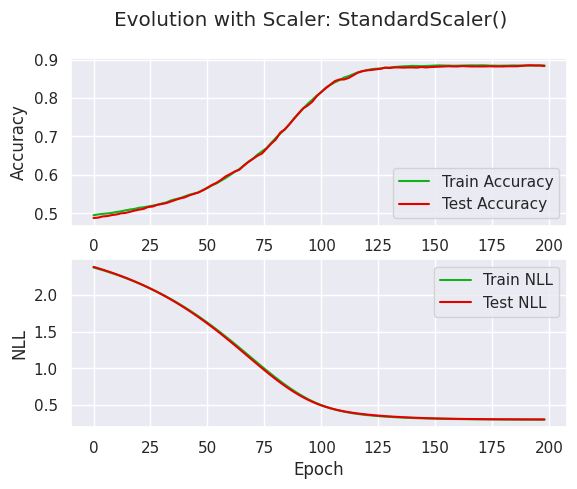

Acuratete folosind RobustScaler: 0.4683698296836983
Precision folosind RobustScaler: 0.07168784029038112
Recall folosind RobustScaler: 0.21525885558583105
F1 Score folosind RobustScaler: 0.10755616065350578


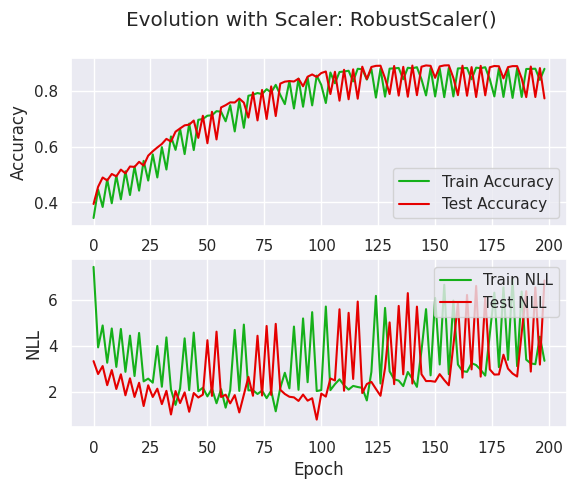


RULAREA NUMARUL 4
Acuratete folosind MinMaxScaler: 0.7927818329278183
Precision folosind MinMaxScaler: 0.13366336633663367
Recall folosind MinMaxScaler: 0.0743801652892562
F1 Score folosind MinMaxScaler: 0.09557522123893807


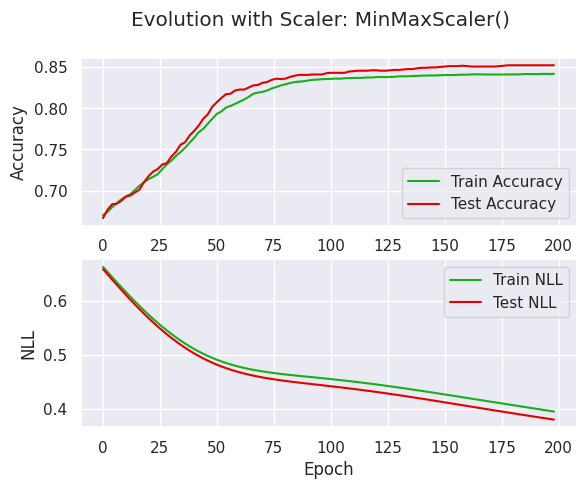

Acuratete folosind StandardScaler: 0.3613138686131387
Precision folosind StandardScaler: 0.07969507969507969
Recall folosind StandardScaler: 0.31767955801104975
F1 Score folosind StandardScaler: 0.12742382271468142


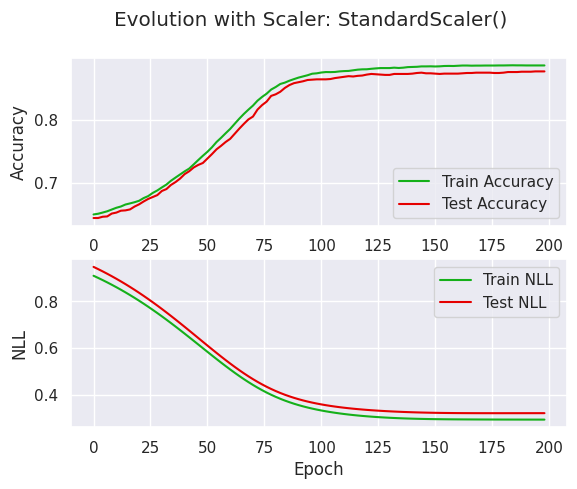

Acuratete folosind RobustScaler: 0.648418491484185
Precision folosind RobustScaler: 0.1362940275650842
Recall folosind RobustScaler: 0.22704081632653061
F1 Score folosind RobustScaler: 0.17033492822966503


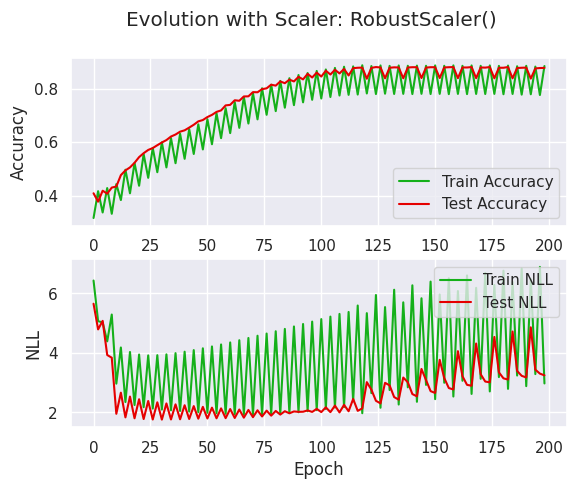


RULAREA NUMARUL 5
Acuratete folosind MinMaxScaler: 0.8248175182481752
Precision folosind MinMaxScaler: 0.10752688172043011
Recall folosind MinMaxScaler: 0.027855153203342618
F1 Score folosind MinMaxScaler: 0.04424778761061947


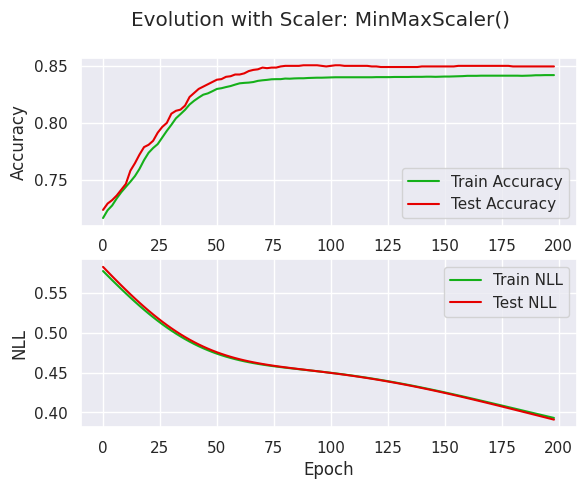

Acuratete folosind StandardScaler: 0.3195458231954582
Precision folosind StandardScaler: 0.06754966887417219
Recall folosind StandardScaler: 0.27419354838709675
F1 Score folosind StandardScaler: 0.10839532412327312


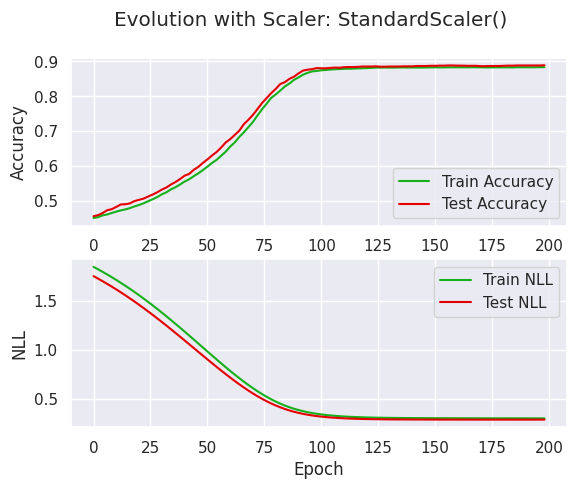

Acuratete folosind RobustScaler: 0.4416058394160584
Precision folosind RobustScaler: 0.04181818181818182
Recall folosind RobustScaler: 0.12466124661246612
F1 Score folosind RobustScaler: 0.06262763784887679


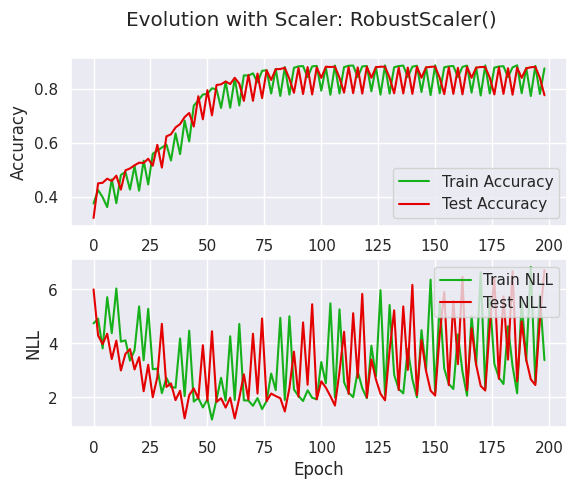


RULAREA NUMARUL 6
Acuratete folosind MinMaxScaler: 0.791970802919708
Precision folosind MinMaxScaler: 0.07643312101910828
Recall folosind MinMaxScaler: 0.031578947368421054
F1 Score folosind MinMaxScaler: 0.0446927374301676


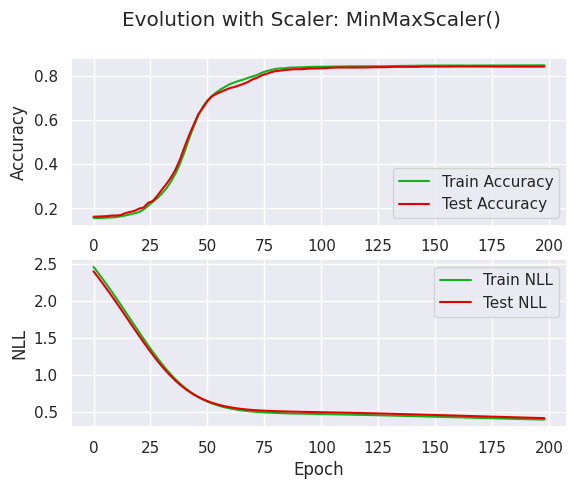

Acuratete folosind StandardScaler: 0.32684509326845096
Precision folosind StandardScaler: 0.05142460041695622
Recall folosind StandardScaler: 0.2005420054200542
F1 Score folosind StandardScaler: 0.08185840707964602


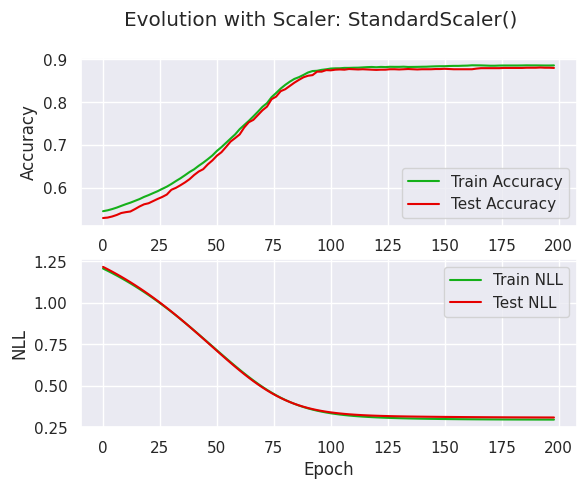

Acuratete folosind RobustScaler: 0.45093268450932683
Precision folosind RobustScaler: 0.04380952380952381
Recall folosind RobustScaler: 0.11616161616161616
F1 Score folosind RobustScaler: 0.0636237897648686


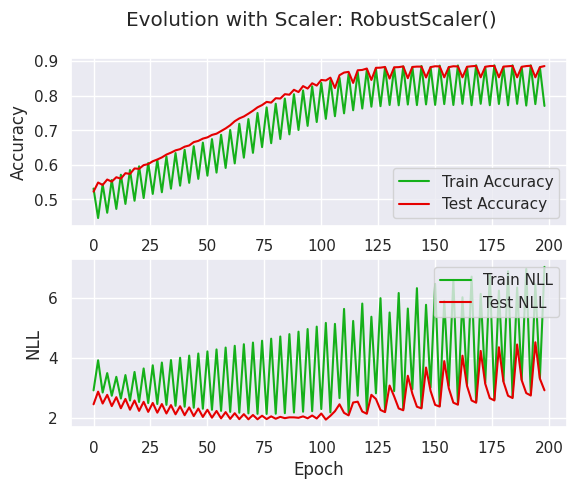


RULAREA NUMARUL 7
Acuratete folosind MinMaxScaler: 0.6504460665044607
Precision folosind MinMaxScaler: 0.1069182389937107
Recall folosind MinMaxScaler: 0.1878453038674033
F1 Score folosind MinMaxScaler: 0.13627254509018036


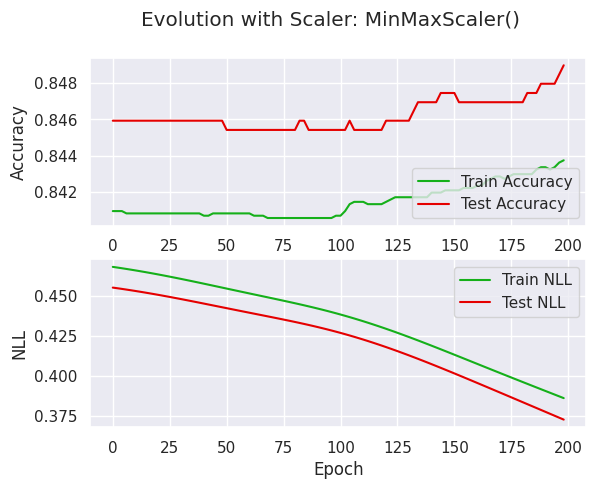

Acuratete folosind StandardScaler: 0.33738848337388483
Precision folosind StandardScaler: 0.07215104517869184
Recall folosind StandardScaler: 0.29315068493150687
F1 Score folosind StandardScaler: 0.11580086580086578


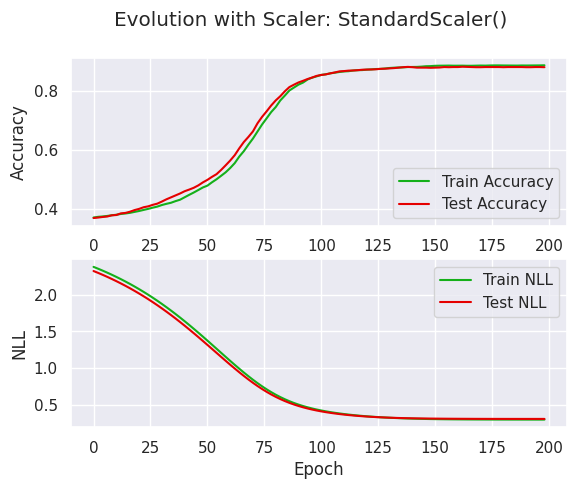

Acuratete folosind RobustScaler: 0.467558799675588
Precision folosind RobustScaler: 0.03009027081243731
Recall folosind RobustScaler: 0.0797872340425532
F1 Score folosind RobustScaler: 0.043699927166788055


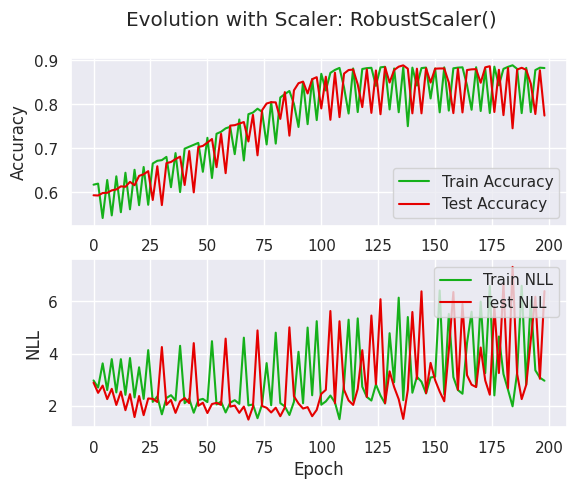


RULAREA NUMARUL 8
Acuratete folosind MinMaxScaler: 0.5085158150851582
Precision folosind MinMaxScaler: 0.07581967213114754
Recall folosind MinMaxScaler: 0.19270833333333334
F1 Score folosind MinMaxScaler: 0.10882352941176472


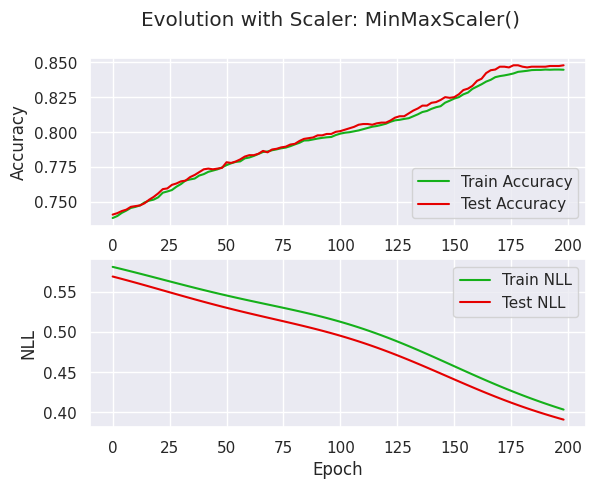

Acuratete folosind StandardScaler: 0.3284671532846715
Precision folosind StandardScaler: 0.06466984343090537
Recall folosind StandardScaler: 0.2519893899204244
F1 Score folosind StandardScaler: 0.10292524377031419


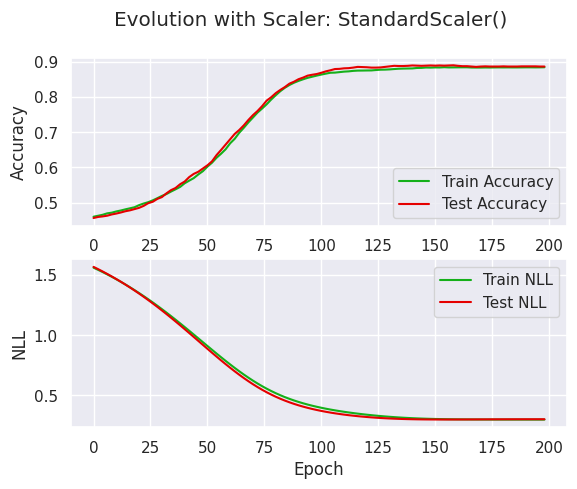

Acuratete folosind RobustScaler: 0.635036496350365
Precision folosind RobustScaler: 0.08791208791208792
Recall folosind RobustScaler: 0.14933333333333335
F1 Score folosind RobustScaler: 0.11067193675889331


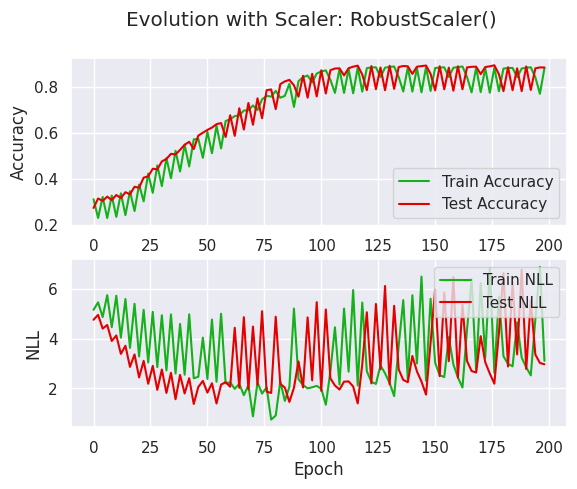


RULAREA NUMARUL 9
Acuratete folosind MinMaxScaler: 0.7964314679643146
Precision folosind MinMaxScaler: 0.11888111888111888
Recall folosind MinMaxScaler: 0.043256997455470736
F1 Score folosind MinMaxScaler: 0.06343283582089553


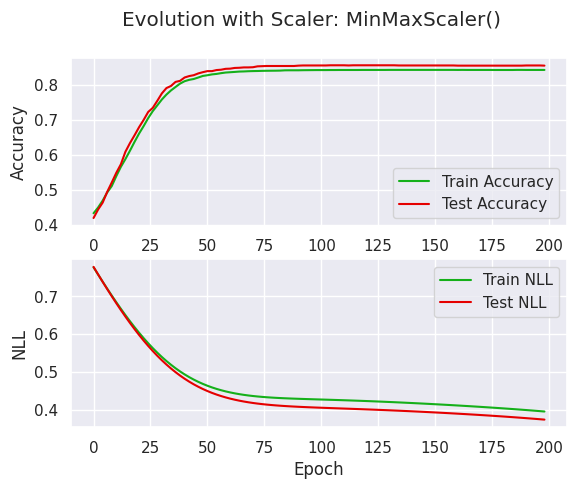

Acuratete folosind StandardScaler: 0.3195458231954582
Precision folosind StandardScaler: 0.059113300492610835
Recall folosind StandardScaler: 0.1976470588235294
F1 Score folosind StandardScaler: 0.09100758396533044


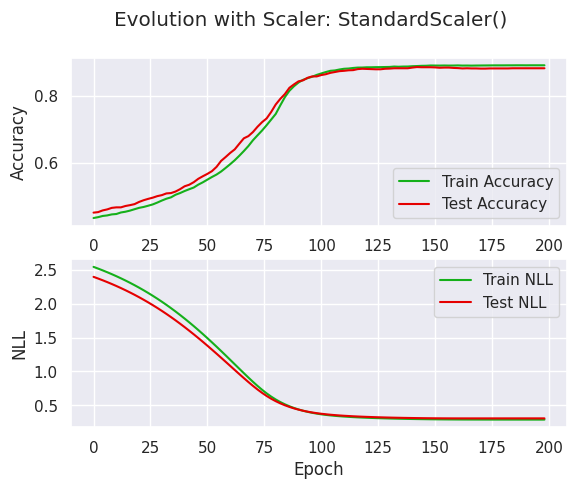

Acuratete folosind RobustScaler: 0.4744525547445255
Precision folosind RobustScaler: 0.05205205205205205
Recall folosind RobustScaler: 0.12967581047381546
F1 Score folosind RobustScaler: 0.07428571428571429


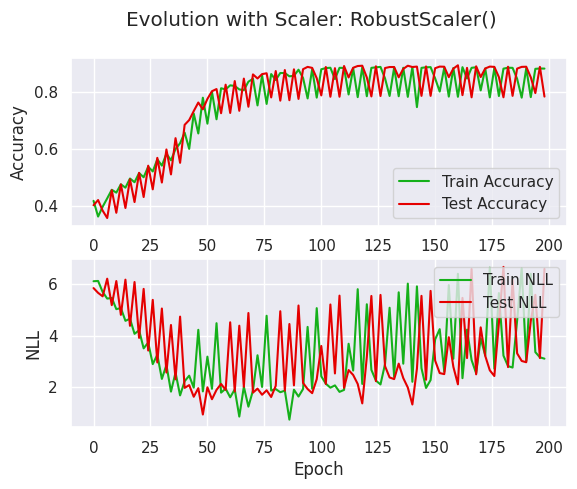


RULAREA NUMARUL 10
Acuratete folosind MinMaxScaler: 0.8467153284671532
Precision folosind MinMaxScaler: 0.0
Recall folosind MinMaxScaler: 0.0
F1 Score folosind MinMaxScaler: 0.0


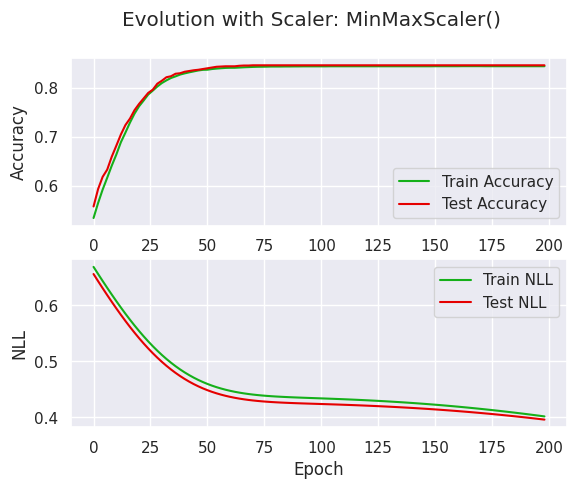

Acuratete folosind StandardScaler: 0.3329278183292782
Precision folosind StandardScaler: 0.05890603085553997
Recall folosind StandardScaler: 0.21705426356589147
F1 Score folosind StandardScaler: 0.09266409266409266


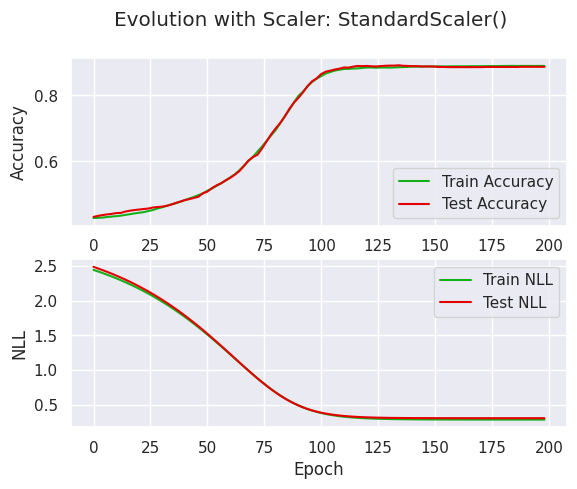

Acuratete folosind RobustScaler: 0.49148418491484186
Precision folosind RobustScaler: 0.01978021978021978
Recall folosind RobustScaler: 0.04736842105263158
F1 Score folosind RobustScaler: 0.02790697674418605


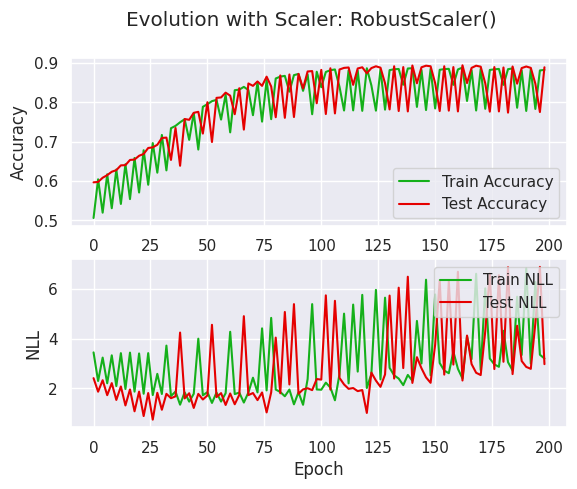


FINAL STATISTICS

ACCURACY

Metrics for Accuracy with MinMaxScaler after 10 runs:
Mean Accuracy: 0.7417274939172749
Median Accuracy: 0.7923763179237632
Variance Accuracy: 0.012934299004991809
Min Accuracy: 0.5085158150851582
Max Accuracy: 0.8491484184914841

Metrics for Accuracy with StandardScaler after 10 runs:
Mean Accuracy: 0.34144363341443634
Median Accuracy: 0.3288726682887267
Variance Accuracy: 0.0011698104768238147
Min Accuracy: 0.3195458231954582
Max Accuracy: 0.43795620437956206

Metrics for Accuracy with RobustScaler after 10 runs:
Mean Accuracy: 0.5152879156528791
Median Accuracy: 0.4720194647201946
Variance Accuracy: 0.005856256606474165
Min Accuracy: 0.4416058394160584
Max Accuracy: 0.648418491484185

PRECISION

Metrics for Precision with MinMaxScaler after 10 runs:
Mean Precision: 0.08690964169593444
Median Precision: 0.1031828764029327
Variance Precision: 0.002356186699102853
Min Precision: 0.0
Max Precision: 0.15040650406504066

Metrics for Precision with StandardScal

In [2153]:
# Print information about the training dataset
(N, D) = df.shape
print(f"Training dataset size: {N}")
print(f"Number of features: {D - 1}")

# Create dictionaries to store metric values
precision_results = {}
recall_results = {}
f1_score_results = {}
accuracy_results = {}

for iteration in range(num_iterations):
    # Amestecarea (randomizarea) rândurilor
    df = df.sample(frac=1).reset_index(drop=True)
    # Preprocesarea datelor
    X, y = preprocess_data(df.copy())

    print(f"\nRULAREA NUMARUL {iteration + 1}")
    # Apelul funcției cu datele specifice
    logistic_regression_manual(X,y,lr=LR,learning_increase_percent=LEARNING_INCREASE_PERCENT,epochs_no=EPOCHS_NO,step_percent=STEP_PERCENT)
    del X, y

print("\nFINAL STATISTICS")
# Print accuracy metrics
print("\nACCURACY")
print_metrics("Accuracy", accuracy_results, num_iterations)
# Print precision metrics
print("\nPRECISION")
print_metrics("Precision", precision_results, num_iterations)
# Print recall metrics
print("\nRECALL")
print_metrics("Recall", recall_results, num_iterations)
# Print F1 score metrics
print("\nF1")
print_metrics("F1 Score", f1_score_results, num_iterations)

del precision_results, recall_results, f1_score_results, accuracy_results

### 2. Implementare folosind scikit-learn

In [2154]:
# Print information about the training dataset
(N, D) = df.shape
print(f"Training dataset size: {N}")
print(f"Number of features: {D - 1}")

# Create dictionaries to store metric values
precision_results = {}
recall_results = {}
f1_score_results = {}
accuracy_results = {}

for iteration in range(num_iterations):
    # Amestecarea (randomizarea) rândurilor
    df = df.sample(frac=1).reset_index(drop=True)
    X, y = preprocess_data(df.copy())

    print(f"\nRUN NUMBER {iteration + 1}")

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Iterate over the scalers
    for scaler_name, scaler in scalers.items():
        # Scale the features
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Create and train the logistic regression model
        model = LogisticRegression(random_state=None)
        model.fit(X_train_scaled, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test_scaled)

        # Evaluate the model
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Save metric values in dictionaries
        accuracy_results[f"{scaler_name}_Run_{iteration + 1}"] = accuracy
        precision_results[f"{scaler_name}_Run_{iteration + 1}"] = precision
        recall_results[f"{scaler_name}_Run_{iteration + 1}"] = recall
        f1_score_results[f"{scaler_name}_Run_{iteration + 1}"] = f1

        # Print evaluation metrics for each run and scaler
        print(f"\nMetrics for {scaler_name} - Run {iteration + 1}:")
        print(f"Accuracy: {accuracy}")
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(f"F1 Score: {f1}")

        # Clean up variables
        del model

    # Clean up remaining variables
    del X, y, X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled

print("\nFINAL STATISTICS")
# Print accuracy metrics
print("\nACCURACY")
print_metrics("Accuracy", accuracy_results, num_iterations)
# Print precision metrics
print("\nPRECISION")
print_metrics("Precision", precision_results, num_iterations)
# Print recall metrics
print("\nRECALL")
print_metrics("Recall", recall_results, num_iterations)
# Print F1 score metrics
print("\nF1")
print_metrics("F1 Score", f1_score_results, num_iterations)

# Clean up remaining variables
del precision_results, recall_results, f1_score_results, accuracy_results

Training dataset size: 12330
Number of features: 17

RUN NUMBER 1

Metrics for MinMaxScaler - Run 1:
Accuracy: 0.8734793187347932
Precision: 0.78
Recall: 0.29545454545454547
F1 Score: 0.4285714285714286

Metrics for StandardScaler - Run 1:
Accuracy: 0.883617193836172
Precision: 0.7684729064039408
Recall: 0.3939393939393939
F1 Score: 0.5208681135225375


/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi


Metrics for RobustScaler - Run 1:
Accuracy: 0.8815896188158961
Precision: 0.76
Recall: 0.3838383838383838
F1 Score: 0.5100671140939597

RUN NUMBER 2

Metrics for MinMaxScaler - Run 2:
Accuracy: 0.8759124087591241
Precision: 0.7608695652173914
Recall: 0.2777777777777778
F1 Score: 0.4069767441860465

Metrics for StandardScaler - Run 2:
Accuracy: 0.8872668288726683
Precision: 0.7659574468085106
Recall: 0.38095238095238093
F1 Score: 0.508833922261484

Metrics for RobustScaler - Run 2:
Accuracy: 0.8876723438767234
Precision: 0.7616580310880829
Recall: 0.3888888888888889
F1 Score: 0.5148861646234677

RUN NUMBER 3

Metrics for MinMaxScaler - Run 3:
Accuracy: 0.8734793187347932
Precision: 0.7588652482269503
Recall: 0.2779220779220779
F1 Score: 0.4068441064638783

Metrics for StandardScaler - Run 3:
Accuracy: 0.8864557988645579
Precision: 0.772020725388601
Recall: 0.38701298701298703
F1 Score: 0.5155709342560554

Metrics for RobustScaler - Run 3:
Accuracy: 0.8876723438767234
Precision: 0.76732

/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi


Metrics for RobustScaler - Run 4:
Accuracy: 0.8799675587996756
Precision: 0.748898678414097
Recall: 0.4156479217603912
F1 Score: 0.5345911949685536

RUN NUMBER 5

Metrics for MinMaxScaler - Run 5:
Accuracy: 0.8726682887266829
Precision: 0.7638888888888888
Recall: 0.28205128205128205
F1 Score: 0.41198501872659177

Metrics for StandardScaler - Run 5:
Accuracy: 0.8848337388483374
Precision: 0.7623762376237624
Recall: 0.39487179487179486
F1 Score: 0.5202702702702703

Metrics for RobustScaler - Run 5:
Accuracy: 0.8860502838605029
Precision: 0.7658536585365854
Recall: 0.4025641025641026
F1 Score: 0.5277310924369747

RUN NUMBER 6

Metrics for MinMaxScaler - Run 6:
Accuracy: 0.8718572587185726
Precision: 0.7746478873239436
Recall: 0.27918781725888325
F1 Score: 0.41044776119402987

Metrics for StandardScaler - Run 6:
Accuracy: 0.8819951338199513
Precision: 0.7696335078534031
Recall: 0.3730964467005076
F1 Score: 0.5025641025641027

Metrics for RobustScaler - Run 6:
Accuracy: 0.8824006488240065


/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi


Metrics for RobustScaler - Run 7:
Accuracy: 0.8811841038118411
Precision: 0.775609756097561
Recall: 0.3916256157635468
F1 Score: 0.5204582651391162

RUN NUMBER 8

Metrics for MinMaxScaler - Run 8:
Accuracy: 0.8698296836982968
Precision: 0.7398843930635838
Recall: 0.31683168316831684
F1 Score: 0.44367417677642984

Metrics for StandardScaler - Run 8:
Accuracy: 0.8771289537712895
Precision: 0.7244444444444444
Recall: 0.4034653465346535
F1 Score: 0.5182829888712241

Metrics for RobustScaler - Run 8:
Accuracy: 0.878345498783455
Precision: 0.7321428571428571
Recall: 0.40594059405940597
F1 Score: 0.5222929936305732

RUN NUMBER 9

Metrics for MinMaxScaler - Run 9:
Accuracy: 0.8824006488240065
Precision: 0.7938931297709924
Recall: 0.28337874659400547
F1 Score: 0.4176706827309237


/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regressi


Metrics for StandardScaler - Run 9:
Accuracy: 0.8925385239253852
Precision: 0.7741935483870968
Recall: 0.3923705722070845
F1 Score: 0.5207956600361664

Metrics for RobustScaler - Run 9:
Accuracy: 0.8905109489051095
Precision: 0.7650273224043715
Recall: 0.3814713896457766
F1 Score: 0.509090909090909

RUN NUMBER 10

Metrics for MinMaxScaler - Run 10:
Accuracy: 0.8803730738037308
Precision: 0.7664233576642335
Recall: 0.28532608695652173
F1 Score: 0.41584158415841577

Metrics for StandardScaler - Run 10:
Accuracy: 0.8888888888888888
Precision: 0.7526881720430108
Recall: 0.3804347826086957
F1 Score: 0.5054151624548737

Metrics for RobustScaler - Run 10:
Accuracy: 0.889294403892944
Precision: 0.7567567567567568
Recall: 0.3804347826086957
F1 Score: 0.5063291139240508

FINAL STATISTICS

ACCURACY

Metrics for Accuracy with MinMaxScaler_Run_1 after 10 runs:
Mean Accuracy: 0.8734793187347932
Median Accuracy: 0.8734793187347932
Variance Accuracy: 0.0
Min Accuracy: 0.8734793187347932
Max Accuracy:

/home/stefan/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## 3.2.2. Arbore de Decizie

### 1. Implementare folosind scikit-learn

### 2. Implementare manuală